## NOTEBOOK TESIS

En primer lugar importo las librerias necesarias para trabajar la tesis 

In [1]:
import pandasql as ps
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
# Offline mode
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import random_split, TensorDataset  
from torch.autograd import Variable 
import numpy as np
import os
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing


In [2]:
import tensorflow as tf
print(tf.__version__)



2.10.0


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential

### Base Demanda Epec

En esta sección voy a cargar los data frame y organizar las tablas para visualizarlas y limpiarlas

In [4]:
# Definir el separador y cargar el archivo CSV
separador = ';'
trainv6 = pd.read_csv('./../bases/demandaepecv6csv.csv', sep=separador, encoding='ISO-8859-1')

# Eliminar filas con valores nulos y restablecer el índice
trainv6 = trainv6.dropna()
trainv6 = trainv6.reset_index(drop=True)

#Para ordenar la columna Fecha del data frame para que pase de tener el formato de pandas 21/7/2023 23:00 al formato '2019-12-31 00:00:00'
trainv6['Fecha'] = pd.to_datetime(trainv6['Fecha'], format='%d/%m/%Y %H:%M')
trainv6['Fecha'] = trainv6['Fecha'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Duplicar la columna 'Fecha sin hora' y convertirla al formato '2019-01'
trainv6['Fecha-Mes'] = pd.to_datetime(trainv6['Fecha sin hora'], format='%d/%m/%Y').dt.strftime('%Y-%m')

# Reordenar las columnas fecha, fecha sin hora y fecha-mes
column_order = ['Fecha', 'Fecha sin hora', 'Fecha-Mes'] + [col for col in trainv6.columns if col not in ['Fecha', 'Fecha sin hora', 'Fecha-Mes']]
trainv6 = trainv6[column_order]

#Ahora vamos a copiar la columna Fecha a otra columna y usar la funcion pop para extraer la columna y guardarla en una variable temporal
trainv6['Fecha_copia'] = trainv6['Fecha']
fecha_copia = trainv6.pop('Fecha_copia')

# Usando insert() para insertar la columna en la posición deseada con el nuevo nombre
posicion_deseada = trainv6.columns.get_loc('Demanda')
trainv6.insert(posicion_deseada, 'Fecha_columna', fecha_copia)

# Ordena el DataFrame por la columna 'Fecha'
trainv6['Fecha'] = pd.to_datetime(trainv6['Fecha'])
trainv6 = trainv6.sort_values(by='Fecha')

# Convertir las columnas a números en formato float
trainv6['Demanda'] = trainv6['Demanda'].str.replace(',', '.').astype(float)
trainv6['Temperatura'] = trainv6['Temperatura'].str.replace(',', '.').astype(float)
columnas_a_convertir_float = ['Potencia maxima', 'E valle', 'E resto', 'E pico', 'E total', 'Humedad', 'Acumulacion de lluvia', 'Rafaga de viento']
trainv6[columnas_a_convertir_float] = trainv6[columnas_a_convertir_float].replace(',', '.', regex=True).astype(float)

# Convertir la columna 'Fecha sin hora' y 'Fecha-Mes' a tipo datetime
trainv6['Fecha sin hora'] = pd.to_datetime(trainv6['Fecha sin hora'], format='%d/%m/%Y')
trainv6['Fecha-Mes'] = pd.to_datetime(trainv6['Fecha-Mes'], format='%Y-%m')

#Mostrar el data frame:
trainv6

Fecha Fecha sin hora  Fecha-Mes   Ano  Mes  Dia  \
0     2019-01-01 00:00:00     2019-01-01 2019-01-01  2019    1    1   
1     2019-01-01 01:00:00     2019-01-01 2019-01-01  2019    1    1   
2     2019-01-01 02:00:00     2019-01-01 2019-01-01  2019    1    1   
3     2019-01-01 03:00:00     2019-01-01 2019-01-01  2019    1    1   
4     2019-01-01 04:00:00     2019-01-01 2019-01-01  2019    1    1   
...                   ...            ...        ...   ...  ...  ...   
39403 2023-06-30 19:00:00     2023-06-30 2023-06-01  2023    6   30   
39404 2023-06-30 20:00:00     2023-06-30 2023-06-01  2023    6   30   
39405 2023-06-30 21:00:00     2023-06-30 2023-06-01  2023    6   30   
39406 2023-06-30 22:00:00     2023-06-30 2023-06-01  2023    6   30   
39407 2023-06-30 23:00:00     2023-06-30 2023-06-01  2023    6   30   

       Dia de la semana  Hora-num      Hora        Fecha_columna  ...  \
0                     1         0  00:00:00  2019-01-01 00:00:00  ...   
1                     1         1  01:00:00  2019-01-01 01:00:00  ...   
2                     1         2  02:00:00  2019-01-01 02:00:00  ...   
3                     1         3  03:00:00  2019-01-01 03:00:00  ...   
4                     1         4  04:00:00  2019-01-01 04:00:00  ...   
...                 ...       ...       ...                  ...  ...   
39403                 4        19  19:00:00  2023-06-30 19:00:00  ...   
39404                 4        20  20:00:00  2023-06-30 20:00:00  ...   
39405                 4        21  21:00:00  2023-06-30 21:00:00  ...   
39406                 4        22  22:00:00  2023-06-30 22:00:00  ...   
39407                 4        23  23:00:00  2023-06-30 23:00:00  ...   

        E pico   E total  Nombre de la semana Tipo de dia  Laborabilidad  \
0      6202.45  25623.35               martes     Feriado              0   
1      6202.45  25623.35               martes     Feriado              0   
2      6202.45  25623.35               martes     Feriado              0   
3      6202.45  25623.35               martes     Feriado              0   
4      6202.45  25623.35               martes     Feriado              0   
...        ...       ...                  ...         ...            ...   
39403  7396.32  31532.26              viernes       Habil              1   
39404  7396.32  31532.26              viernes       Habil              1   
39405  7396.32  31532.26              viernes       Habil              1   
39406  7396.32  31532.26              viernes       Habil              1   
39407  7396.32  31532.26              viernes       Habil              1   

       Estacion  Temperatura  Humedad Acumulacion de lluvia Rafaga de viento  
0        Verano        26.80    65.32                   0.0             11.3  
1        Verano        26.55    65.62                   0.0              0.0  
2        Verano        26.40    66.32                   0.0              0.0  
3        Verano        26.40    66.75                   0.0              0.0  
4        Verano        26.35    68.05                   0.0             36.5  
...         ...          ...      ...                   ...              ...  
39403  Invierno        14.67    52.32                   0.0            138.3  
39404  Invierno        13.32    55.32                   0.0            114.2  
39405  Invierno        12.22    58.77                   0.0             82.0  
39406  Invierno        11.65    60.67                   0.0            100.6  
39407  Invierno        11.12    64.62                   0.0             56.8  

[39408 rows x 26 columns]

### Base Variables Mensuales, EMAE, Cantidades Electrodomesticos, Cantidad de Clientes

In [5]:
# Definir el separador y cargar el archivo CSV
separador = ';'
trainvariables1 = pd.read_csv('./../bases/variablesmensualesv1.csv', sep=separador, encoding='ISO-8859-1')

# Eliminar filas con valores nulos y restablecer el índice
trainvariables1 = trainvariables1.dropna()
trainvariables1 = trainvariables1.reset_index(drop=True)

# Cambiar el formato de 'Fecha' a formato de fecha
trainvariables1['Fecha'] = pd.to_datetime(trainvariables1['Fecha'], format='%d/%m/%Y')

# Duplicar la columna 'Fecha' y llamarla 'Fecha-Mes'
trainvariables1['Fecha-Mes'] = trainvariables1['Fecha'].dt.strftime('%m/%Y')

# Reordenar las columnas 
column_order = ['Fecha', 'Fecha-Mes'] + [col for col in trainvariables1.columns if col not in ['Fecha', 'Fecha-Mes']]
trainvariables1 = trainvariables1[column_order]

# Reemplazar las barras diagonales por guiones y reorganizar el formato de 'Fecha-Mes'
trainvariables1['Fecha-Mes'] = pd.to_datetime(trainvariables1['Fecha-Mes'], format='%m/%Y').dt.strftime('%Y-%m')

# Convertir la columna 'Fecha-Mes' a tipo datetime
trainvariables1['Fecha-Mes'] = pd.to_datetime(trainvariables1['Fecha-Mes'], format='%Y-%m')

#Transformar columnas a formato deseado, primero remplazando ',' por '.', y luego convertirla a float
columnas_a_transformar = [
    "indice Serie Original\n2004=100",
    "indice Serie Desestacionalizada\n2004=100",
    "indice Serie Tendencia-Ciclo\n2004=100",
    "indice Electricidad gas y agua \n2004=100",
    "Variacion porcentual "
]

for columna in columnas_a_transformar:
    trainvariables1[columna] = trainvariables1[columna].str.replace(',', '.')

columnas_a_convertir = [
    'indice Serie Original\n2004=100',
    'indice Serie Desestacionalizada\n2004=100',
    'indice Serie Tendencia-Ciclo\n2004=100',
    'indice Electricidad gas y agua \n2004=100'
]

trainvariables1[columnas_a_convertir] = trainvariables1[columnas_a_convertir].astype(float)

columna_variacion = 'Variacion porcentual '
trainvariables1[columna_variacion] = trainvariables1[columna_variacion].str.replace(',', '.').str.rstrip('%').astype('float') / 100.0

# Mostrar el DataFrame
trainvariables1

Fecha  Fecha-Mes  indice Serie Original\n2004=100  \
0  2019-01-01 2019-01-01                       134.536240   
1  2019-02-01 2019-02-01                       132.267889   
2  2019-03-01 2019-03-01                       144.963255   
3  2019-04-01 2019-04-01                       149.916221   
4  2019-05-01 2019-05-01                       164.135699   
5  2019-06-01 2019-06-01                       150.858972   
6  2019-07-01 2019-07-01                       146.777030   
7  2019-08-01 2019-08-01                       141.276935   
8  2019-09-01 2019-09-01                       134.877067   
9  2019-10-01 2019-10-01                       141.639337   
10 2019-11-01 2019-11-01                       137.771830   
11 2019-12-01 2019-12-01                       135.765154   
12 2020-01-01 2020-01-01                       133.891086   
13 2020-02-01 2020-02-01                       128.973639   
14 2020-03-01 2020-03-01                       128.211061   
15 2020-04-01 2020-04-01                       113.295035   
16 2020-05-01 2020-05-01                       131.029569   
17 2020-06-01 2020-06-01                       132.521965   
18 2020-07-01 2020-07-01                       127.463687   
19 2020-08-01 2020-08-01                       125.183893   
20 2020-09-01 2020-09-01                       127.175079   
21 2020-10-01 2020-10-01                       131.345512   
22 2020-11-01 2020-11-01                       132.068659   
23 2020-12-01 2020-12-01                       133.854351   
24 2021-01-01 2021-01-01                       131.787340   
25 2021-02-01 2021-02-01                       126.505090   
26 2021-03-01 2021-03-01                       146.222811   
27 2021-04-01 2021-04-01                       147.332683   
28 2021-05-01 2021-05-01                       151.221209   
29 2021-06-01 2021-06-01                       149.031474   
30 2021-07-01 2021-07-01                       142.612043   
31 2021-08-01 2021-08-01                       141.160931   
32 2021-09-01 2021-09-01                       141.481895   
33 2021-10-01 2021-10-01                       140.433080   
34 2021-11-01 2021-11-01                       144.670461   
35 2021-12-01 2021-12-01                       148.149225   
36 2022-01-01 2022-01-01                       138.187701   
37 2022-02-01 2022-02-01                       136.881377   
38 2022-03-01 2022-03-01                       152.778434   
39 2022-04-01 2022-04-01                       155.799957   
40 2022-05-01 2022-05-01                       162.954281   
41 2022-06-01 2022-06-01                       159.375278   
42 2022-07-01 2022-07-01                       151.242419   
43 2022-08-01 2022-08-01                       150.228610   
44 2022-09-01 2022-09-01                       148.131542   
45 2022-10-01 2022-10-01                       146.288470   
46 2022-11-01 2022-11-01                       147.789621   
47 2022-12-01 2022-12-01                       145.734624   
48 2023-01-01 2023-01-01                       142.239018   
49 2023-02-01 2023-02-01                       137.058115   
50 2023-03-01 2023-03-01                       154.653400   
51 2023-04-01 2023-04-01                       149.043553   
52 2023-05-01 2023-05-01                       153.811294   
53 2023-06-01 2023-06-01                       151.941008   

    indice Serie Desestacionalizada\n2004=100  \
0                                  141.685420   
1                                  143.849475   
2                                  141.900682   
3                                  142.453119   
4                                  144.901664   
5                                  143.886068   
6                                  145.824179   
7                                  144.910269   
8                                  140.648894   
9                                  143.820945   
10                                 140.972357   
11                                 139.932554   
12             

Para combinar las dos bases era necesario crear la columna Fecha-Mes, ya que una esta en horas y dias y la otra mensual. Ahora si ya se pueden unir:

In [6]:
Comb = trainvariables1.merge(trainv6, on='Fecha-Mes', how='left', suffixes=('', '_v6')).filter(regex='^(?!Fecha_)')
Comb

Fecha  Fecha-Mes  indice Serie Original\n2004=100  \
0     2019-01-01 2019-01-01                       134.536240   
1     2019-01-01 2019-01-01                       134.536240   
2     2019-01-01 2019-01-01                       134.536240   
3     2019-01-01 2019-01-01                       134.536240   
4     2019-01-01 2019-01-01                       134.536240   
...          ...        ...                              ...   
39403 2023-06-01 2023-06-01                       151.941008   
39404 2023-06-01 2023-06-01                       151.941008   
39405 2023-06-01 2023-06-01                       151.941008   
39406 2023-06-01 2023-06-01                       151.941008   
39407 2023-06-01 2023-06-01                       151.941008   

       indice Serie Desestacionalizada\n2004=100  \
0                                     141.685420   
1                                     141.685420   
2                                     141.685420   
3                                     141.685420   
4                                     141.685420   
...                                          ...   
39403                                 145.241481   
39404                                 145.241481   
39405                                 145.241481   
39406                                 145.241481   
39407                                 145.241481   

       indice Serie Tendencia-Ciclo\n2004=100  \
0                                  142.673954   
1                                  142.673954   
2                                  142.673954   
3                                  142.673954   
4                                  142.673954   
...                                       ...   
39403                              147.730442   
39404                              147.730442   
39405                              147.730442   
39406                              147.730442   
39407                              147.730442   

       indice Electricidad gas y agua \n2004=100  Variacion porcentual   \
0                                     145.727414              -0.000396   
1                                     145.727414              -0.000396   
2                                     145.727414              -0.000396   
3                                     145.727414              -0.000396   
4                                     145.727414              -0.000396   
...                                          ...                    ...   
39403                                 154.313955              -0.000507   
39404                                 154.313955              -0.000507   
39405                                 154.313955              -0.000507   
39406                                 154.313955              -0.000507   
39407                                 154.313955              -0.000507   

       Cantidad de servicios  Cantidad de personas  Cant vendidas televisores  \
0                     824424                719759                      88089   
1                     824424                719759                      88089   
2                     824424                719759                      88089   
3                     824424                719759                      88089   
4                     824424                719759                      88089   
...                      ...                   ...                        ...   
39403                1112503                934487                     122438   
39404                1112503                934487                     122438   
39405                1112503                934487                     122438   
39406                1112503                934487                     122438   
39407                1112503                934487                     122438   

       ...   E pico   E total  Nombre de la semana  Tipo de dia  \
0      ...  6202.45  25623.35               martes      Feriado   
1      ...  6202.45 

Para armar un resultado por Año sobre la media de las principales variables 

In [7]:
# Asegúrate de que 'Fecha' sea de tipo datetime
Comb['Fecha'] = pd.to_datetime(Comb['Fecha'])

# Extraer el año y crear una nueva columna llamada 'Año'
Comb['Año'] = Comb['Fecha'].dt.year

# Lista de columnas para las cuales deseas calcular la media
columnas_para_media = [
    'Demanda', 'Potencia maxima','Temperatura', 'Humedad', 'Acumulacion de lluvia', 'Rafaga de viento',
    'indice Serie Original\n2004=100', 'indice Serie Desestacionalizada\n2004=100',
    'indice Serie Tendencia-Ciclo\n2004=100',
    'indice Electricidad gas y agua \n2004=100', 'Variacion porcentual ',
    'Cantidad de servicios', 'Cantidad de personas',
    'Cant vendidas televisores', 'Cant vendidas heladeras',
    'Cant vendidas aire acondicionados', 'Cant vendidas lavarropas',
    'Cant vendidas lavavajillas', 'Cant vendidas cocinas a gas',
    'Cant vendidas cocina electricas',
    'Cant vendidas calefactores y estufas a gas',
    'Cant vendidas calefactores o estufas electricas',
    'Cant vendidas  calefones y termotanques',
    'Cant vendidas pequenos electrodomesticos',
    'Cant vendidas ventiladores'
]

# Calcular la media después de agrupar por año
resultados_por_año = Comb.groupby('Año')[columnas_para_media].mean()
resultados_por_año


Demanda  Potencia maxima  Temperatura    Humedad  \
Año                                                          
2019  1044.564420      1294.076110    19.632578  57.078430   
2020  1028.638506      1268.312787    20.059193  49.269910   
2021  1072.412330      1309.638986    18.353556  60.487559   
2022  1150.634615      1399.769836    19.110739  51.526068   
2023  1198.153810      1450.095856    21.537539  59.429655   

      Acumulacion de lluvia  Rafaga de viento  \
Año                                             
2019               0.054566         53.311815   
2020               0.105760        101.152880   
2021               0.076142         97.339680   
2022               0.052397        120.638870   
2023               0.075046        115.536901   

      indice Serie Original\n2004=100  \
Año                                     
2019                       142.981169   
2020                       128.777081   
2021                       142.648832   
2022                       149.686085   
2023                       148.281653   

      indice Serie Desestacionalizada\n2004=100  \
Año                                               
2019                                 142.900947   
2020                                 128.743980   
2021                                 142.579827   
2022                                 149.613928   
2023                                 147.725458   

      indice Serie Tendencia-Ciclo\n2004=100  \
Año                                            
2019                              142.478737   
2020                              137.589910   
2021                              142.319027   
2022                              149.490084   
2023                              148.069543   

      indice Electricidad gas y agua \n2004=100  ...  \
Año                                              ...   
2019                                 139.184800  ...   
2020                                 141.212143  ...   
2021                                 145.921378  ...   
2022                                 149.750157  ...   
2023                                 151.394823  ...   

      Cant vendidas aire acondicionados  Cant vendidas lavarropas  \
Año                                                                 
2019                       61525.358904              44040.276712   
2020                       50115.284153              33982.745902   
2021                       55311.860274              37521.854795   
2022                       62100.112329              41861.827397   
2023                       49503.182320              45789.320442   

      Cant vendidas lavavajillas  Cant vendidas cocinas a gas  \
Año                                                             
2019                13758.764384                 25646.539726   
2020                 8778.969945                 19794.923497   
2021                 8898.095890                 21816.769863   
2022                10546.260274                 22145.687671   
2023                11551.591160                 22596.867403   

      Cant vendidas cocina electricas  \
Año                                     
2019                     30176.632877   
2020                     23975.341530   
2021                     25579.775342   
2022                     32799.416438   
2023                     30157.895028   

      Cant vendidas calefactores y estufas a gas  \
Año                                                
2019                                11428.389041   
2020                                 9425.486339   
2021                                 9603.394521   
2022                                 9287.575342   
2023                                19092.441989   

      Cant vendidas calefactores o estufas electricas  \
Año                                                     
2019                                     52085.778082   
2020                                     39946.327869   
2021                              

 ### Visualización de variables para predecir

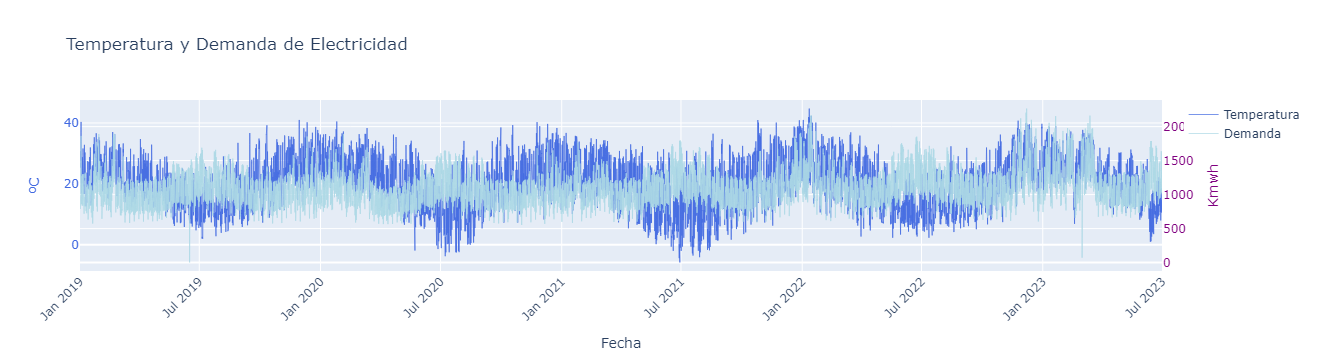

In [8]:
from matplotlib import pyplot as plt
plt.style.use('default')

# Crear y mostrar el gráfico
layout_temp = go.Layout(
    title='Temperatura y Demanda de Electricidad',
    xaxis=dict(title='Fecha', tickangle=-45, dtick='M6'),  # Alinea las etiquetas y establece un intervalo de 6 meses
    yaxis=dict(title='ºC', color='royalblue', titlefont=dict(size=14)),
    yaxis2=dict(title='Kmwh', color='purple', overlaying='y', side='right', titlefont=dict(size=14))
)

temp = go.Scatter(x=trainv6['Fecha'], y=trainv6['Temperatura'], name='Temperatura', line=dict(color='royalblue', width=0.7), yaxis='y')
dem = go.Scatter(x=trainv6['Fecha'], y=trainv6['Demanda'], name='Demanda', line=dict(color='lightblue', width=0.7), yaxis='y2')

fig = go.Figure(data=[temp, dem], layout=layout_temp)
fig.update_xaxes(title_text='Fecha')

fig.show()

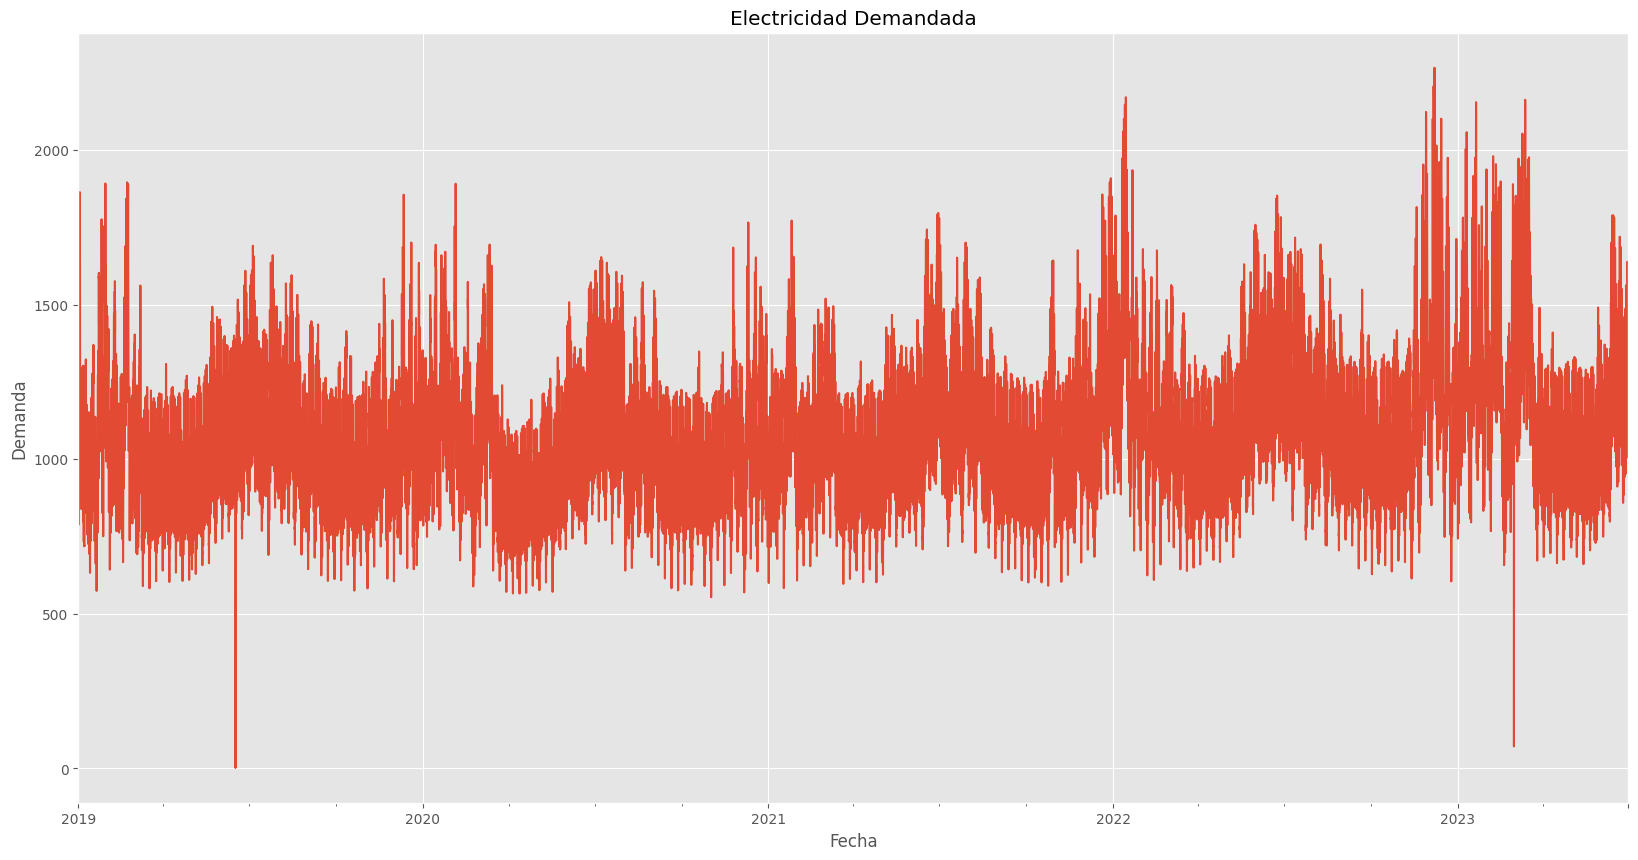

In [9]:
plt.style.use('ggplot')

# Establecer 'Fecha ' como el índice
trainv6.set_index('Fecha', inplace=True)

# Crear el gráfico con la columna 'Demanda' en el eje y
trainv6['Demanda'].plot(title='Electricidad Demandada', figsize=(20, 10))

# Añadir etiquetas a los ejes
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.show()

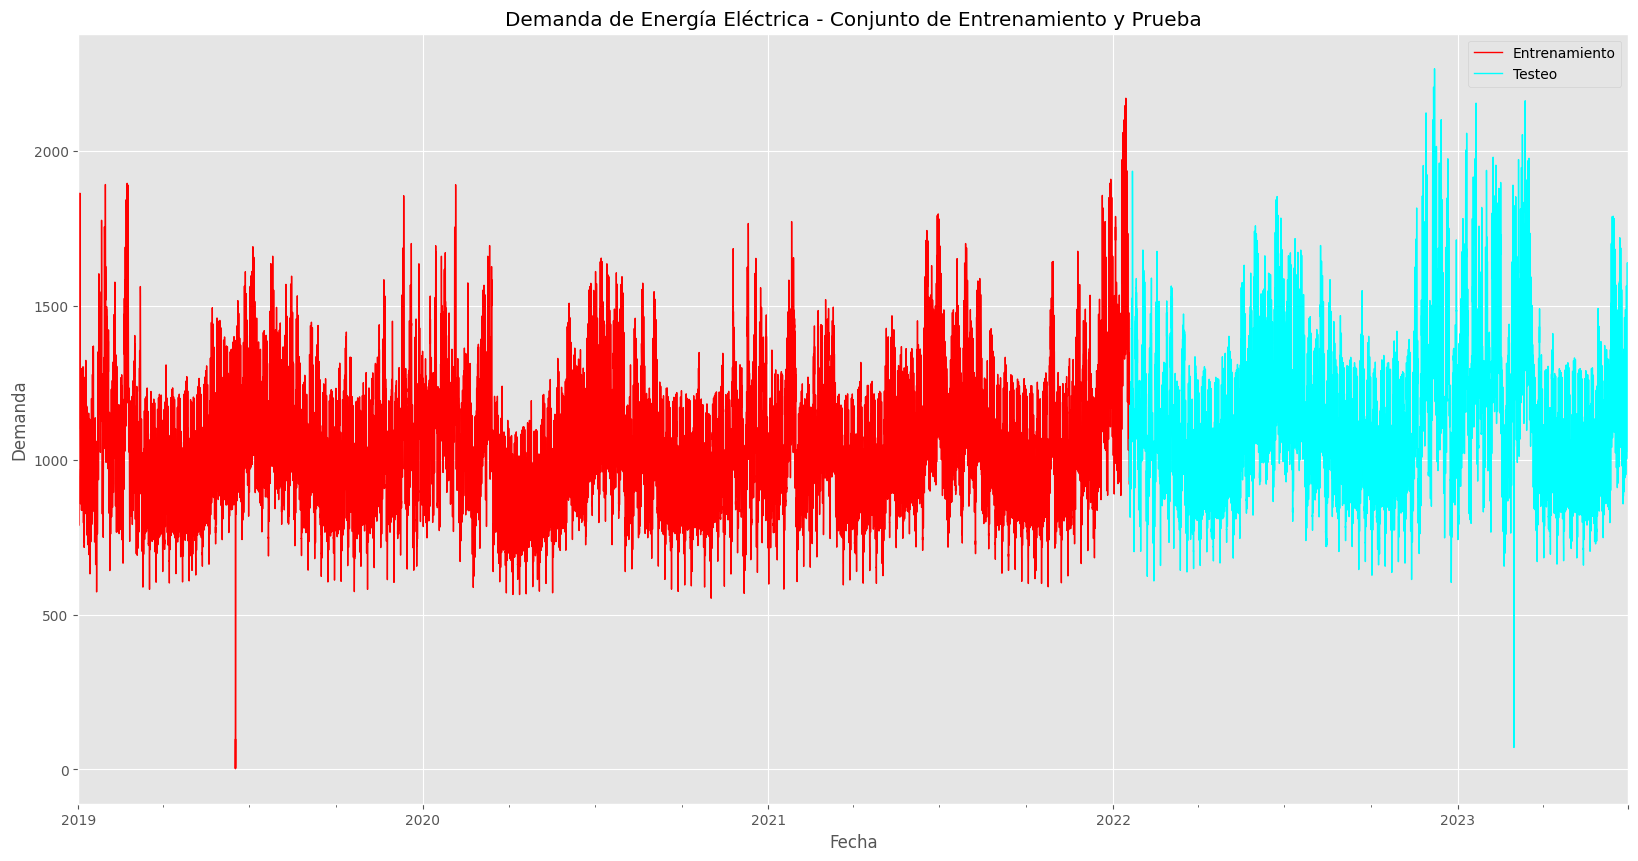

In [10]:
train_size = int(len(trainv6)*0.678)
test_size = len(trainv6) - train_size
train, test = trainv6.iloc[0:train_size, :], trainv6.iloc[train_size:len(trainv6), :]
fig, ax = plt.subplots(figsize=(20, 10)) # Crear una figura y un eje para la visualización
train.Demanda.plot(ax=ax, label='Entrenamiento', linewidth=1, c = 'red')
test.Demanda.plot(ax=ax, label='Testeo', linewidth=1, c = 'cyan')
plt.savefig('Demanda_train_test.pdf')
ax.set_title('Demanda de Energía Eléctrica - Conjunto de Entrenamiento y Prueba')# Configurar título y etiquetas de ejes
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.legend()

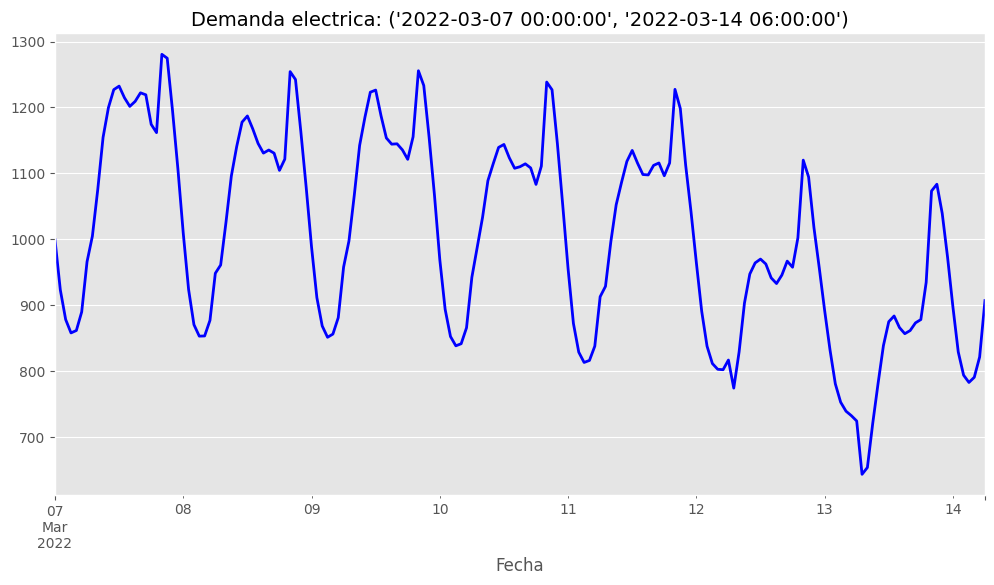

In [11]:
zoom_aux = ('2022-03-07 00:00:00', '2022-03-14 06:00:00')

plt.figure(figsize=(12, 6))

trainv6.loc[zoom_aux[0]: zoom_aux[1]].Demanda.plot(color='blue', linewidth=2)

plt.title(f'Demanda electrica: {zoom_aux}', fontsize=14)
plt.savefig('Demanda_semana.pdf')
plt.show()

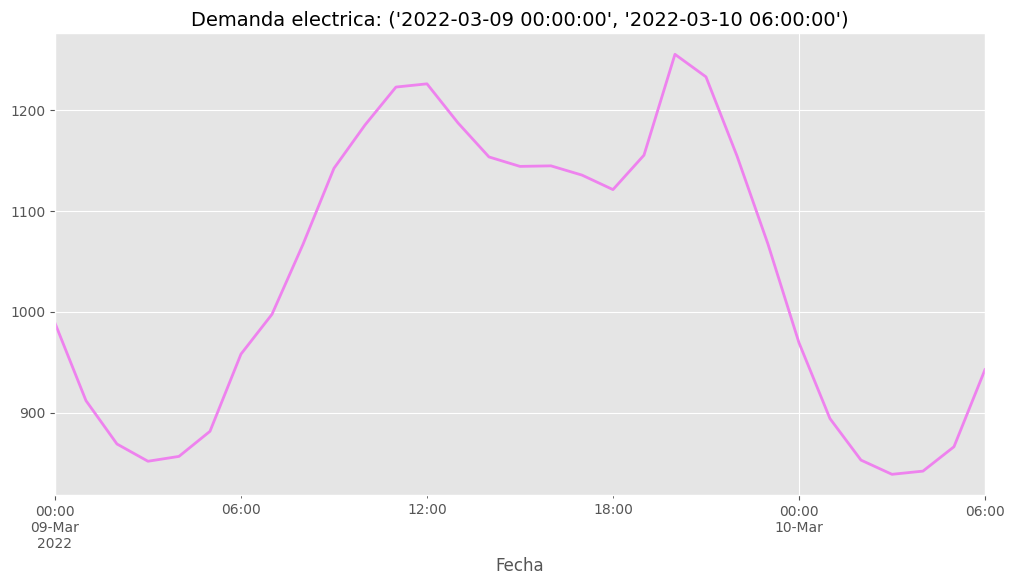

In [12]:
zoom = ('2022-03-09 00:00:00', '2022-03-10 06:00:00')

plt.figure(figsize=(12, 6))

trainv6.loc[zoom[0]: zoom[1]].Demanda.plot(color='violet', linewidth=2)

plt.title(f'Demanda electrica: {zoom}', fontsize=14)
plt.savefig('Demanda_dia.pdf')
plt.show()

### Estadísticas

#### Serie desestacionalizada

A continuacion la serie desestacionalizada con un modelo aditivo, la eleccion de la naturaleza de un modelo depende de la naturaleza de la serie temporal y cómo se comportan las componentes estacionales. Si las fluctuaciones estacionales tienen un efecto constante en la serie a lo largo del tiempo, es más apropiado utilizar un modelo aditivo. Si las fluctuaciones estacionales tienen un efecto proporcional en la serie, es más apropiado utilizar un modelo multiplicativo.

##### Modelo Aditivo

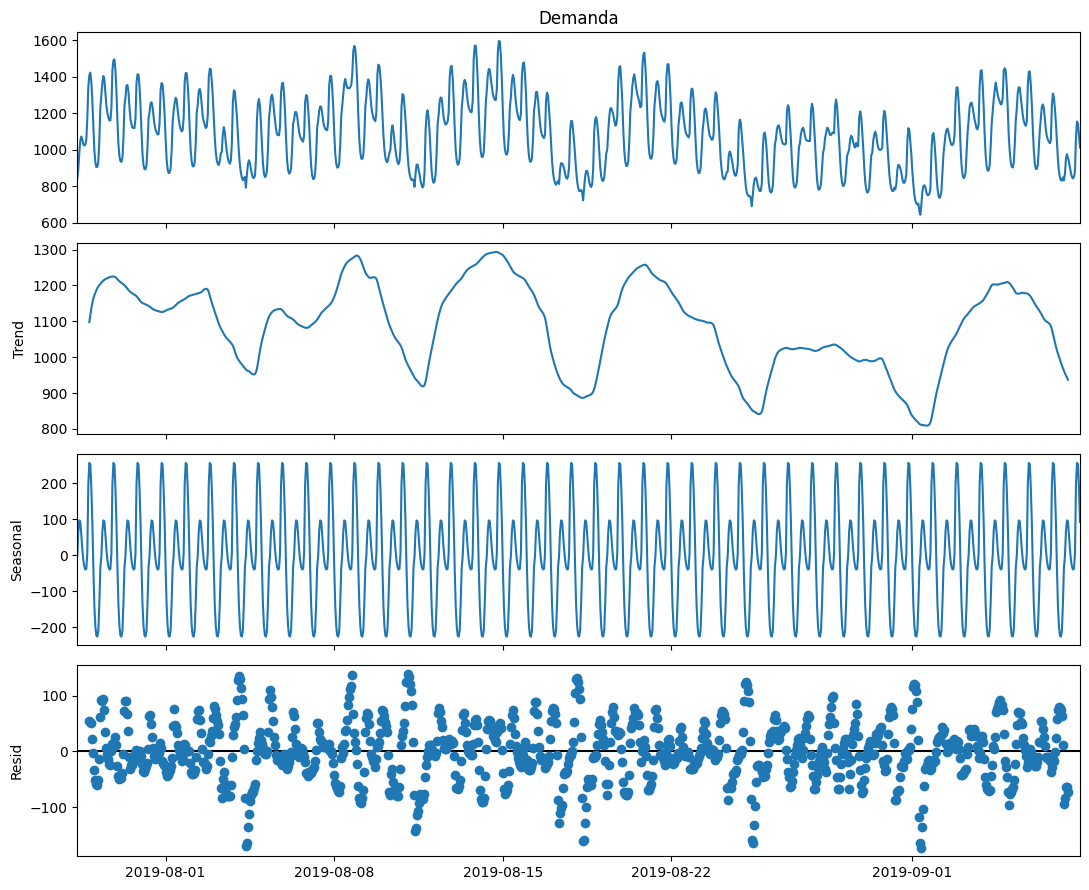

In [13]:
plt.style.use('default')
from statsmodels.tsa.seasonal import seasonal_decompose

# Seleccionar un rango específico de filas
serie_temporal1 = trainv6['Demanda'].iloc[5000:6000]

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# Realizar la descomposición estacional
decomposition = seasonal_decompose(serie_temporal1,  model='additive', period=24)

# Graficar los resultados
decomposition.plot()
plt.show()

##### Modelo Multiplicativo

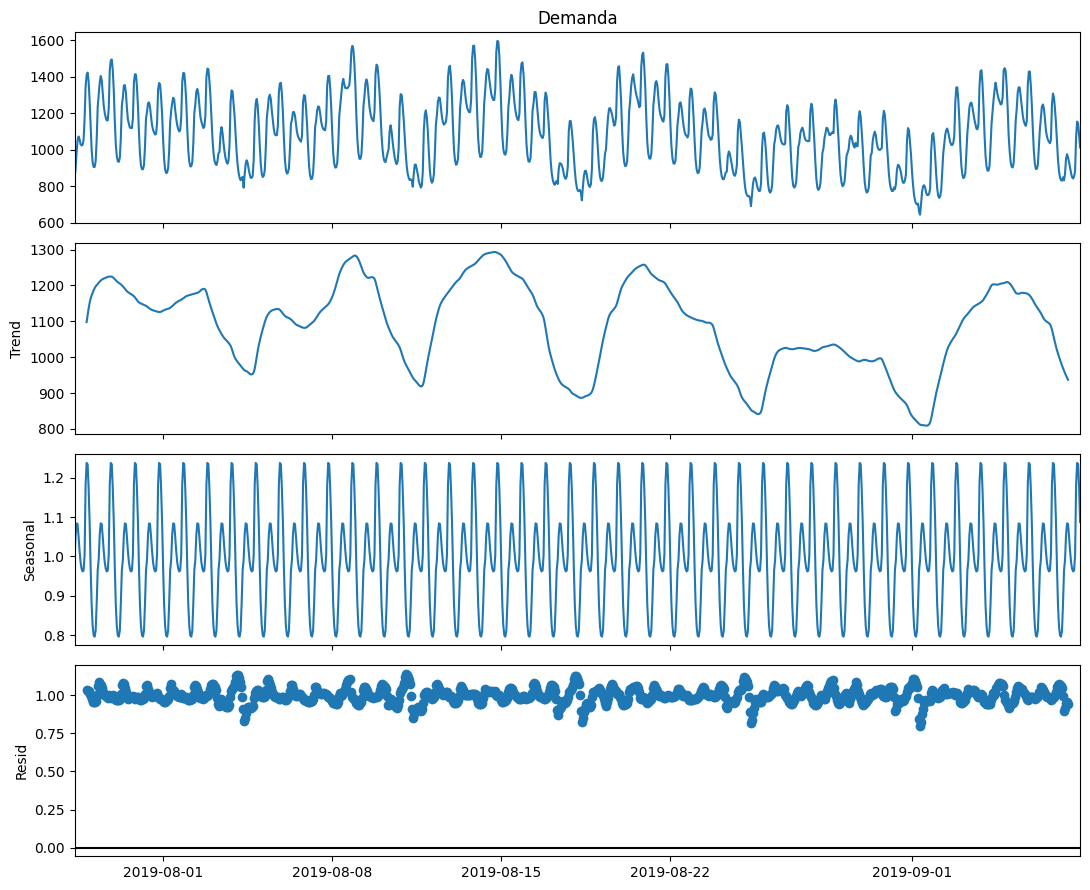

In [14]:
plt.style.use('default')
from statsmodels.tsa.seasonal import seasonal_decompose

# Seleccionar un rango específico de filas
serie_temporal2 = trainv6['Demanda'].iloc[5000:6000]

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# Realizar la descomposición estacional
decomposition = seasonal_decompose(serie_temporal2,  model='multiplicative', period=24)

# Graficar los resultados
decomposition.plot()
plt.show()

##### Comparacion de ambos Modelos: 

In [15]:
# Modelo aditivo
valores_observados_aditivo = serie_temporal1.values
valores_predichos_aditivo = decomposition.trend + decomposition.seasonal

# Cálculo del RMSE (Error Cuadrático Medio)
rmse_aditivo = np.sqrt(np.mean((valores_observados_aditivo - valores_predichos_aditivo) ** 2))

# Cálculo del R-cuadrado (Coeficiente de Determinación)
sst = np.sum((valores_observados_aditivo - np.mean(valores_observados_aditivo)) ** 2)
ssr = np.sum((valores_observados_aditivo - valores_predichos_aditivo) ** 2)
r_cuadrado_aditivo = 1 - (ssr / sst)

# Modelo multiplicativo
valores_observados_multiplicativo = serie_temporal2.values
valores_predichos_multiplicativo = decomposition.trend * decomposition.seasonal

# Cálculo del RMSE (Error Cuadrático Medio)
rmse_multiplicativo = np.sqrt(np.mean((valores_observados_multiplicativo - valores_predichos_multiplicativo) ** 2))

# Cálculo del R-cuadrado (Coeficiente de Determinación)
sst = np.sum((valores_observados_multiplicativo - np.mean(valores_observados_multiplicativo)) ** 2)
ssr = np.sum((valores_observados_multiplicativo - valores_predichos_multiplicativo) ** 2)
r_cuadrado_multiplicativo = 1 - (ssr / sst)

# Mostrar las métricas
print("Métricas para el modelo aditivo:")
print("RMSE (aditivo):", rmse_aditivo)
print("R-cuadrado (aditivo):", r_cuadrado_aditivo)

print("Métricas para el modelo multiplicativo:")
print("RMSE (multiplicativo):", rmse_multiplicativo)
print("R-cuadrado (multiplicativo):", r_cuadrado_multiplicativo)

Métricas para el modelo aditivo:
RMSE (aditivo): 148.61466166962302
R-cuadrado (aditivo): 0.4254611026031
Métricas para el modelo multiplicativo:
RMSE (multiplicativo): 47.24457927367197
R-cuadrado (multiplicativo): 0.9419369167352374


Las métricas indican que el modelo multiplicativo tiene un RMSE significativamente más bajo (mejor ajuste a los datos y comete errores de predicción más pequeños) y un R-cuadrado más alto (mayor proporción de la variabilidad en los datos se explica mediante este modelo) en comparación con el modelo aditivo. Esto sugiere que el modelo multiplicativo se ajusta mejor a tus datos de serie temporal.

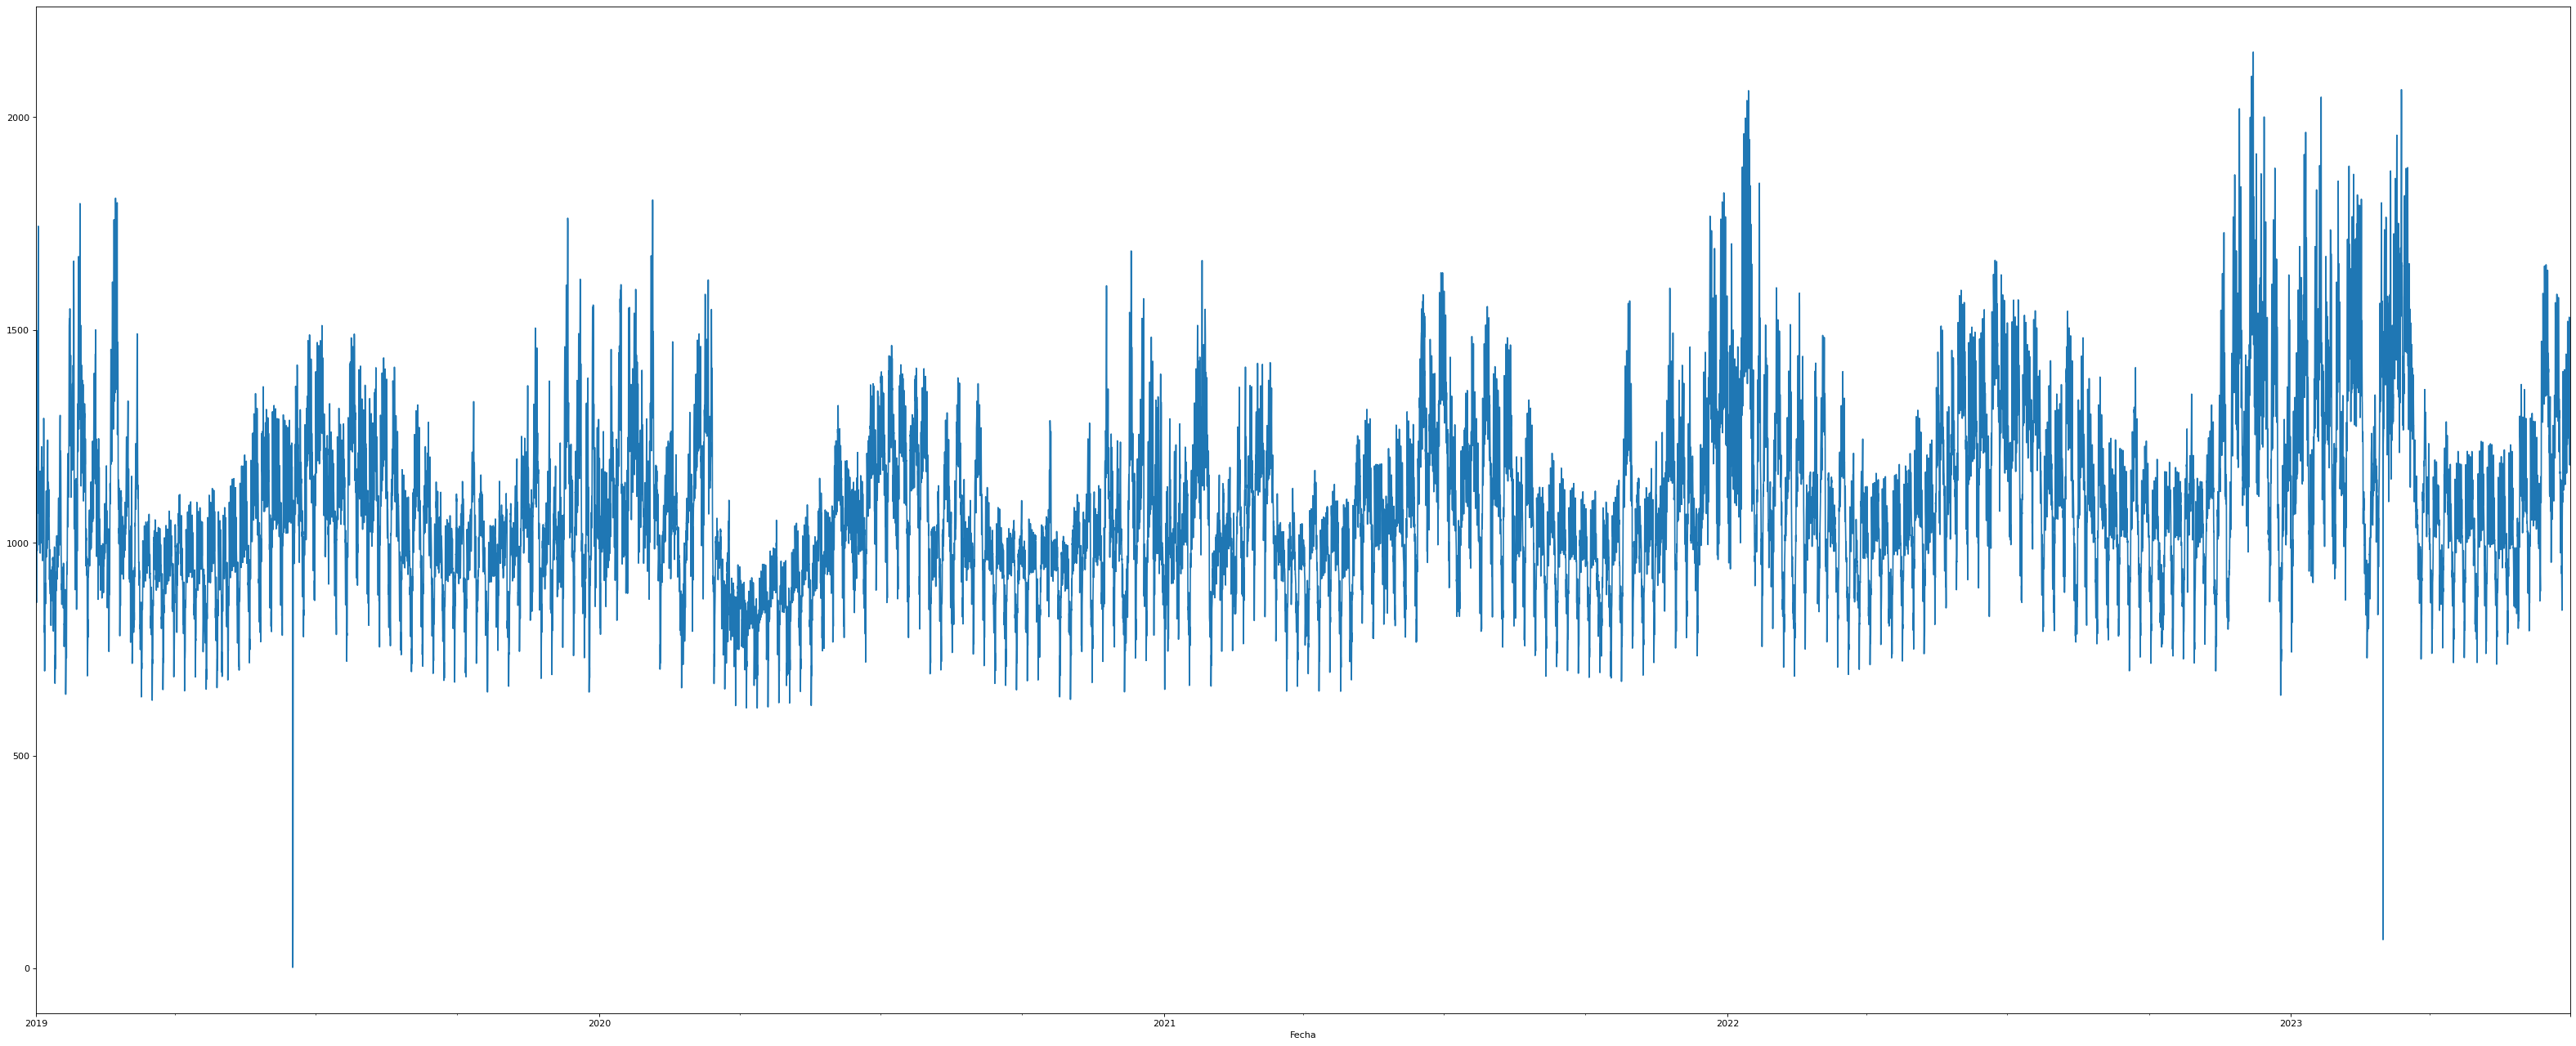

In [16]:
rcParams['figure.figsize'] = 11, 9
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
deseasonalized = seasonal_decompose(trainv6['Demanda'], model = 'multiplicative', period=24)
dem_deseasonalized = deseasonalized.observed / deseasonalized.seasonal
dem_deseasonalized.plot()
plt.show()

El ADF (Augmented Dickey-Fuller) test, o Prueba de Dickey-Fuller es una prueba de hipótesis estadística utilizada para determinar si una serie de tiempo es estacionaria o no estacionaria. Evaluar si una serie temporal tiene raíces unitarias, lo que indica la presencia de tendencia y no estacionariedad. Una raíz unitaria significa que la serie temporal no tiene una media constante y muestra un comportamiento de tendencia. En otras palabras, la serie está cambiando con el tiempo y no se encuentra en equilibrio.

El ADF test compara la serie temporal original con una versión diferenciada de sí misma. La hipótesis nula (H0) del ADF test es que la serie tiene raíces unitarias, lo que implica que no es estacionaria. La hipótesis alternativa (H1) es que la serie no tiene raíces unitarias, lo que implica que es estacionaria.

La prueba genera un estadístico y un valor p. Si el valor p es lo suficientemente bajo (generalmente por debajo de un umbral predefinido, como 0.05), podemos rechazar la hipótesis nula y concluir que la serie es estacionaria. Si el valor p es alto, no podemos rechazar la hipótesis nula y concluimos que la serie no es estacionaria.

In [17]:
# ADF Test
result = adfuller(dem_deseasonalized, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -13.836467556481317
p-value: 7.427379791348873e-26
Critial Values:
   1%, -3.430516181145039
Critial Values:
   5%, -2.8616134482152855
Critial Values:
   10%, -2.5668090941320756


Hay evidencia estadistica suficiente para rechazar la hipotesis nula sobre la existencia de raiz unitaria en la serie,el valor p es lo suficientemente bajo (menor a 0.05), podemos rechazar la hipótesis nula y concluir que la serie es estacionaria.

In [18]:
_ot_19 = pd.date_range('2019-03-21 00:00:00','2019-06-20 23:00:00', freq = 'H')
_ot_20 = pd.date_range('2020-03-21 00:00:00','2020-06-20 23:00:00', freq = 'H')
_ot_21 = pd.date_range('2021-03-21 00:00:00','2021-06-20 23:00:00', freq = 'H')
_ot_22 = pd.date_range('2022-03-21 00:00:00','2022-06-20 23:00:00', freq = 'H')
_ot_23 = pd.date_range('2023-03-21 00:00:00','2023-06-20 23:00:00', freq = 'H')

_spr_19 = pd.date_range('2019-09-21 00:00:00','2019-12-20 23:00:00', freq = 'H')
_spr_20 = pd.date_range('2020-09-21 00:00:00','2020-12-20 23:00:00', freq = 'H')
_spr_21 = pd.date_range('2021-09-21 00:00:00','2021-12-20 23:00:00', freq = 'H')
_spr_22 = pd.date_range('2022-09-21 00:00:00','2022-12-20 23:00:00', freq = 'H')
_spr_23 = pd.date_range('2023-09-21 00:00:00','2023-12-20 23:00:00', freq = 'H')

In [19]:
Comb['Demanda'] = dem_deseasonalized.values
Comb.groupby(['Estacion', 'Ano'])['Demanda'].describe()

count         mean         std         min          25%  \
Estacion  Ano                                                              
Invierno  2019  2208.0  1102.358870  154.023298  693.277396  1001.961812   
          2020  2208.0  1086.326269  163.537857  665.071550   966.885201   
          2021  2208.0  1114.916566  171.500754  686.710097  1002.017836   
          2022  2208.0  1166.975965  179.482335  699.390285  1049.869410   
          2023   240.0  1262.694513  150.246201  841.618194  1166.948928   
Otoño     2019  2208.0   988.966167  142.268092    2.693999   914.285310   
          2020  2208.0   915.441030  119.823786  611.992195   836.860801   
          2021  2208.0  1022.149809  143.435959  651.222880   943.053856   
          2022  2208.0  1097.030806  166.060198  702.776718   994.509781   
          2023  2208.0  1061.201540  145.598204  714.872665   969.023073   
Primavera 2019  2184.0  1017.023715  149.123884  649.565483   936.515433   
          2020  2184.0   992.704232  145.052138  632.144433   917.775839   
          2021  2184.0  1044.760362  160.645724  674.450256   957.041451   
          2022  2184.0  1161.755869  248.352829  699.076526  1015.385314   
Verano    2019  2160.0  1069.389664  205.831165  630.136116   936.184907   
          2020  2184.0  1118.876494  174.664471  659.467166  1002.243417   
          2021  2160.0  1107.338222  191.282001  655.795763   979.094276   
          2022  2160.0  1178.992358  237.724107  642.015409  1027.248024   
          2023  1896.0  1350.347367  249.787370   67.781664  1169.748044   

                        50%          75%          max  
Estacion  Ano                                          
Invierno  2019  1105.902435  1205.590431  1510.435471  
          2020  1080.318838  1211.486129  1463.691685  
          2021  1103.465331  1225.861762  1634.452728  
          2022  1155.342033  1294.987297  1663.766212  
          2023  1265.889890  1361.796503  1584.114722  
Otoño     2019   987.457143  1069.043649  1417.724530  
          2020   896.015100   991.016179  1322.556950  
          2021  1022.431780  1093.859762  1582.965747  
          2022  1073.221864  1203.160546  1593.430116  
          2023  1056.667578  1128.296554  1653.358071  
Primavera 2019  1003.977675  1086.266581  1762.743900  
          2020   982.985062  1047.244060  1685.786621  
          2021  1028.354286  1128.290325  1767.418203  
          2022  1107.606364  1283.768993  2152.853746  
Verano    2019  1032.334818  1171.584389  1809.740537  
          2020  1100.093607  1221.843151  1805.462642  
          2021  1079.674951  1210.982413  1822.268657  
          2022  1149.658468  1300.721820  2062.403706  
          2023  1356.573773  1517.789514  2064.676338

In [20]:
Comb.groupby(['Tipo de dia', 'Ano'])['Demanda'].describe()

count         mean         std         min          25%  \
Tipo de dia Ano                                                              
Domingo     2019  1248.0   872.084500  147.189797    2.693999   768.011039   
            2020  1248.0   888.307293  152.404330  611.992195   775.044066   
            2021  1248.0   908.544155  149.152972  651.222880   796.681338   
            2022  1248.0   967.698116  189.469329  642.015409   823.964217   
            2023   624.0  1039.582598  234.620437  714.872665   872.727353   
Feriado     2019   360.0   968.950016  141.004864  649.429968   876.343655   
            2020   432.0   910.161454  123.911686  664.627960   826.964447   
            2021   360.0   969.351555  122.452304  655.795763   892.157918   
            2022   360.0  1064.000585  225.986556  785.782182   914.930619   
            2023   240.0  1000.166718  127.205858  718.762741   912.262712   
Habil       2019  5904.0  1101.089670  150.733349  805.926838   990.470336   
            2020  5856.0  1079.692671  159.747879  749.316820   965.999439   
            2021  5904.0  1129.780364  153.122173  823.260255  1017.137716   
            2022  5880.0  1213.196792  191.000404  869.392215  1074.006734   
            2023  2880.0  1267.646423  225.526099   67.781664  1085.705625   
Sábado      2019  1248.0   970.104387  129.734058  749.166351   873.802499   
            2020  1248.0   967.241161  138.382913  680.921785   861.472886   
            2021  1248.0   992.946164  136.832031  720.920639   885.782897   
            2022  1272.0  1068.003668  185.668338  798.897045   926.805921   
            2023   600.0  1111.461730  218.654014  830.354483   952.196561   

                          50%          75%          max  
Tipo de dia Ano                                          
Domingo     2019   864.823435   966.697463  1292.510795  
            2020   859.087997   982.633451  1389.742014  
            2021   874.804385  1001.910828  1436.426188  
            2022   922.417304  1058.016492  1748.565660  
            2023   956.569251  1161.520142  1748.942864  
Feriado     2019   965.972562  1085.086874  1328.131366  
            2020   884.613288   981.162077  1323.700957  
            2021   956.165100  1037.578696  1334.598183  
            2022  1004.414762  1130.756488  1913.959210  
            2023   966.596305  1100.519257  1346.532002  
Habil       2019  1066.110738  1181.902012  1809.740537  
            2020  1042.658911  1187.389204  1805.462642  
            2021  1093.885939  1209.613787  1822.268657  
            2022  1164.472183  1313.565909  2152.853746  
            2023  1208.658890  1423.700887  2064.676338  
Sábado      2019   948.158615  1056.238282  1558.722112  
            2020   946.344927  1065.713092  1441.095517  
            2021   967.439467  1077.091516  1427.552081  
            2022  1026.363008  1172.475242  1947.789548  
            2023  1031.607238  1225.110789  1750.613917

### Analisis de Variables

##### Prueba Augmented Dickey-Fuller (ADF) a las Variables

El Augmented Dickey-Fuller (ADF) test es una prueba de raíz unitaria que se utiliza para determinar si una serie temporal es estacionaria o no. La hipótesis nula del ADF es que la serie temporal tiene una raíz unitaria, es decir, no es estacionaria. Si el valor p (p-value) es menor que un umbral específico (como 0.05), se rechaza la hipótesis nula, lo que sugiere que la serie temporal es estacionaria.

In [21]:
from statsmodels.tsa.stattools import adfuller

columns_to_test = [
    'indice Serie Original\n2004=100',
    'indice Serie Tendencia-Ciclo\n2004=100',
    'indice Serie Desestacionalizada\n2004=100',
    'indice Electricidad gas y agua \n2004=100',
    'Variacion porcentual ',
    'Cantidad de servicios',
    'Cantidad de personas',
    'Cant vendidas televisores',
    'Cant vendidas heladeras',
    'Cant vendidas aire acondicionados',
    'Cant vendidas calefactores o estufas electricas',
    'Cant vendidas  calefones y termotanques',
    'Cant vendidas pequenos electrodomesticos',
    'Cant vendidas ventiladores',
    'Hora-num',
    'Año',
    'Potencia maxima',
    'HHMM-num',
    'Demanda',
    'Temperatura',
    'Humedad', 
    'Acumulacion de lluvia',
    'Rafaga de viento'
]

# Definir el umbral de significancia para el p-value
p_value_threshold = 0.05

# Listas para almacenar variables estacionarias y no estacionarias
estacionarias = []
no_estacionarias = []

for column in columns_to_test:
    result = adfuller(Comb[column], autolag='AIC')
    adf_statistic, p_value, _, _, _, _ = result
    
    print(f'ADF Statistic {column}: {adf_statistic}')
    print(f'p-value {column}: {p_value}')

    # Clasificar la variable como estacionaria o no estacionaria
    if p_value <= p_value_threshold:
        estacionarias.append(column)
    else:
        no_estacionarias.append(column)

    print('-' * 50)

# Mostrar listas finales
print("Variables estacionarias:", estacionarias)
print("Variables no estacionarias:", no_estacionarias)


ADF Statistic indice Serie Original
2004=100: -2.507253829281387
p-value indice Serie Original
2004=100: 0.11371935104292002
--------------------------------------------------
ADF Statistic indice Serie Tendencia-Ciclo
2004=100: 0.07087355662045267
p-value indice Serie Tendencia-Ciclo
2004=100: 0.9640153051947828
--------------------------------------------------
ADF Statistic indice Serie Desestacionalizada
2004=100: -1.6947428663229778
p-value indice Serie Desestacionalizada
2004=100: 0.43382312559090774
--------------------------------------------------
ADF Statistic indice Electricidad gas y agua 
2004=100: -4.169791263373094
p-value indice Electricidad gas y agua 
2004=100: 0.0007409267318240359
--------------------------------------------------
ADF Statistic Variacion porcentual : -4.855798915769055
p-value Variacion porcentual : 4.24833632859857e-05
--------------------------------------------------
ADF Statistic Cantidad de servicios: 0.7297178449981148
p-value Cantidad de serv

Ahora sera necesario transformar variables categóricas en variables numéricas. En otras palabras, asigna un número entero único a cada categoría presente en una columna categórica.Cuando trabajas con algoritmos de aprendizaje automático, muchos de ellos requieren que todas las variables de entrada sean numéricas. LabelEncoder es útil en situaciones donde tienes variables categóricas (como nombres de ciudades, tipos de día, estaciones, etc.) y necesitas convertirlas a valores numéricos.

In [22]:
le = preprocessing.LabelEncoder()
Comb['HHMM'] = le.fit_transform(Comb['HHMM'])



#### Correlación de las Variables

##### Mapa de calor de Correlación

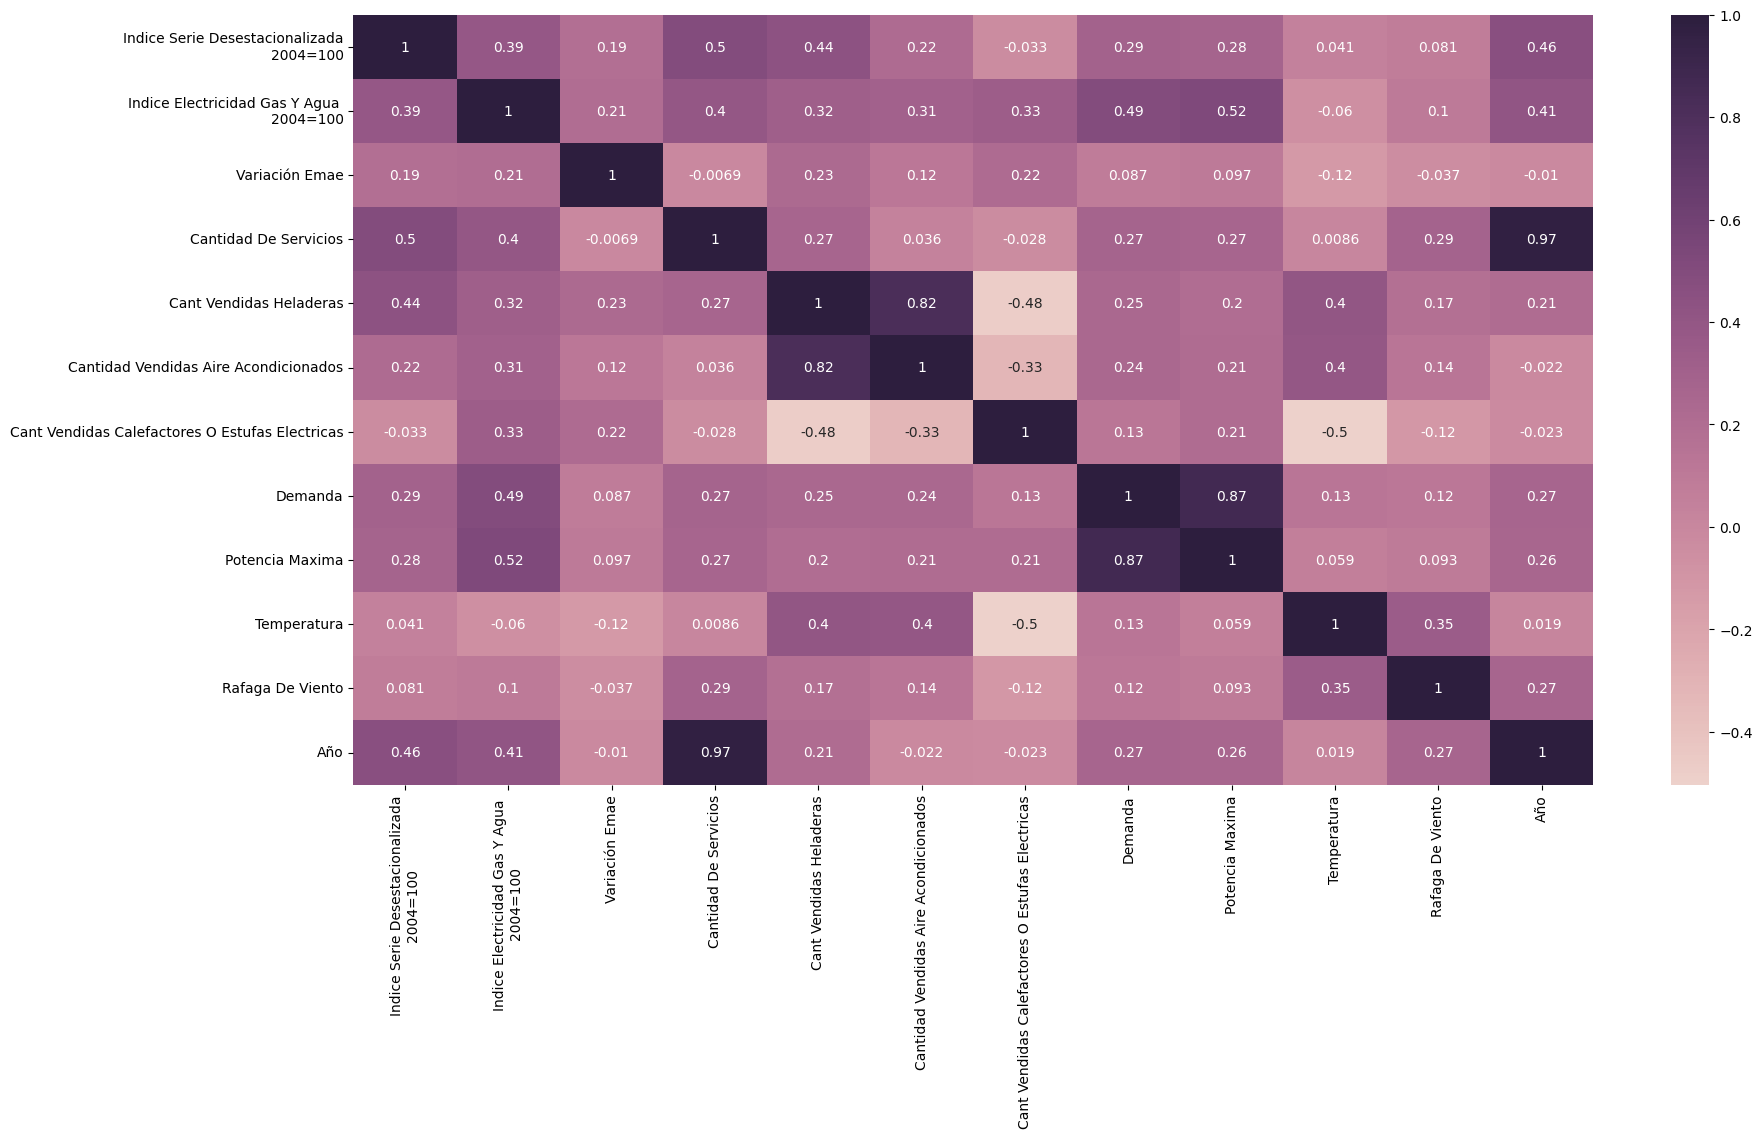

In [23]:
# Eliminar columnas no deseadas
columns_to_drop = [
       'indice Serie Original\n2004=100',
       'indice Serie Tendencia-Ciclo\n2004=100',
       'Cantidad de personas',
       'Cant vendidas televisores', 'Cant vendidas lavarropas',
       'Cant vendidas lavavajillas', 'Cant vendidas cocinas a gas',
       'Cant vendidas cocina electricas',
       'Cant vendidas calefactores y estufas a gas',
       'Cant vendidas  calefones y termotanques',
       'Cant vendidas pequenos electrodomesticos',
       'Cant vendidas ventiladores', 'Ano', 'Mes', 'Dia',
       'Dia de la semana', 'Hora-num', 'HHMM', 'E valle', 'E resto', 'E pico', 'E total',
       'Nombre de la semana', 'Tipo de dia', 'Laborabilidad', 'Estacion',
       'Humedad', 'Acumulacion de lluvia','HHMM-num'
  
]

# Renombrar las columnas deseadas
columns_to_rename = {
    'Cant vendidas aire acondicionados': 'Cantidad Vendidas Aire Acondicionados',
    'Variacion porcentual ': 'Variación EMAE'
}

# Eliminar columnas no deseadas y renombrar las demás
corr = Comb.drop(columns=columns_to_drop)
corr.rename(columns=columns_to_rename, inplace=True)

# Calcular la matriz de correlación con el parámetro numeric_only=True
corr_matrix = corr.corr(numeric_only=True)

# Lista de nombres para las etiquetas de los ejes x e y
h_labels = [x.replace('_', ' ').title() for x in list(corr_matrix.columns.values)]

# Crear una figura y establecer el tamaño
fig, ax = plt.subplots(figsize=(20, 10))

# Crear el mapa de calor con anotaciones
sns.heatmap(
    corr_matrix,
    annot=True,
    xticklabels=h_labels,
    yticklabels=h_labels,
    cmap=sns.cubehelix_palette(as_cmap=True),
    ax=ax
)

# Guardar la figura en un archivo PNG (puedes cambiar el formato según tus preferencias)
plt.savefig('corr_adapted.png', bbox_inches='tight', pad_inches=0.5, transparent=True)

# Mostrar el gráfico
plt.show()




##### Correlación estadisticos Spearman y Kendall

La correlación lineal es un método estadístico que permite cuantificar la relación lineal existente entre dos variables, esta puede ser positiva, negativa o nula.  Existen varios estadísticos, llamados coeficientes de correlación lineal, desarrollados con el objetivo de medir este tipo de asociación, algunos de los más empleados son Pearson, Spearman y Kendall.

La correlación de Kendall es una medida no paramétrica de la relación entre dos variables ordinales. En general, es una buena elección cuando los datos no cumplen con los supuestos de normalidad y la relación no es necesariamente lineal.

En el análisis de correlación de Kendall, una variable se considera no correlacionada cuando el p-value asociado es alto (por ejemplo, mayor a 0.05), lo que sugiere que no hay evidencia estadística suficiente para rechazar la hipótesis nula de no correlación.

las variables que muestran correlación significativa con la demanda pueden ser importantes en la estimación y predicción de la demanda, y su inclusión en modelos predictivos podría mejorar la precisión de las predicciones.

In [24]:
_cols = ['indice Serie Original\n2004=100', 'indice Serie Desestacionalizada\n2004=100', 'indice Serie Tendencia-Ciclo\n2004=100', 'indice Electricidad gas y agua \n2004=100', 'Variacion porcentual ', 'Cantidad de servicios', 'Cantidad de personas', 'Cant vendidas televisores', 'Cant vendidas heladeras', 'Cant vendidas aire acondicionados', 'Cant vendidas lavarropas', 'Cant vendidas lavavajillas', 'Cant vendidas cocinas a gas', 'Cant vendidas cocina electricas', 'Cant vendidas calefactores y estufas a gas', 'Cant vendidas calefactores o estufas electricas', 'Cant vendidas  calefones y termotanques', 'Cant vendidas pequenos electrodomesticos', 'Cant vendidas ventiladores', 'Ano', 'Mes', 'Dia', 'Dia de la semana', 'Hora-num',  'Potencia maxima', 'HHMM-num',  'Temperatura', 'Humedad', 'Acumulacion de lluvia', 'Rafaga de viento', 'Año'
    ]

# Calcular correlaciones con la columna 'Demanda'
for col in _cols:
    if col != 'Demanda':
        corr, p_value = stats.kendalltau(Comb['Demanda'], Comb[col])
        corr_spearman, pvalue_spearman = stats.spearmanr(Comb['Demanda'], Comb[col])

        print(f"Kendall rank correlation coefficient {col}:", corr)
        print(f"Spearman rank correlation coefficient {col}:", corr_spearman)
        print("p-value:", p_value)
        print("p-value:", pvalue_spearman)
        print("-" * 50)

Kendall rank correlation coefficient indice Serie Original
2004=100: 0.11492100954060609
Spearman rank correlation coefficient indice Serie Original
2004=100: 0.16940836384960298
p-value: 5.362229756819321e-252
p-value: 1.6060914993174641e-251
--------------------------------------------------
Kendall rank correlation coefficient indice Serie Desestacionalizada
2004=100: 0.20913916232341898
Spearman rank correlation coefficient indice Serie Desestacionalizada
2004=100: 0.3050373962392118
p-value: 0.0
p-value: 0.0
--------------------------------------------------
Kendall rank correlation coefficient indice Serie Tendencia-Ciclo
2004=100: 0.1722147727137679
Spearman rank correlation coefficient indice Serie Tendencia-Ciclo
2004=100: 0.2548131094617566
p-value: 0.0
p-value: 0.0
--------------------------------------------------
Kendall rank correlation coefficient indice Electricidad gas y agua 
2004=100: 0.3374802711696761
Spearman rank correlation coefficient indice Electricidad gas y 

In [25]:
# Crear una nueva columna 'Tipo de dia categ' con la categorización
Comb['Tipo de dia categ'] = Comb['Tipo de dia'].map({'Feriado': 0, 'Sábado': 1, 'Domingo': 3, 'Habil': 2})

# Crear dos grupos según la nueva columna 'Tipo de dia categ'
grupo_fds = Comb[Comb['Tipo de dia categ'].isin([0, 1, 3])]
grupo_habil = Comb[Comb['Tipo de dia categ'] == 2]

# Extraer las columnas de demanda para cada grupo
demanda_grupo_fds = grupo_fds['Demanda']
demanda_grupo_habil = grupo_habil['Demanda']


# Crear una nueva columna 'Estacion categ' con la categorización
Comb['Estacion categ'] = Comb['Estacion'].map({'Verano': 0, 'Primavera': 1, 'Otoño': 2, 'Invierno': 3})


# Crear dos grupos según la nueva columna 'Estacion categ'
grupo_verano_invierno = Comb[Comb['Estacion categ'].isin([0, 3])]
grupo_primavera_otono = Comb[Comb['Estacion categ'].isin([1, 2])]

# Extraer las columnas de demanda para cada grupo
demanda_grupo_verano_invierno = grupo_verano_invierno['Demanda']
demanda_grupo_primavera_otono = grupo_primavera_otono['Demanda']


In [26]:
# Extraer las columnas de demanda para cada grupo
demanda_grupo_fds = grupo_fds['Demanda'].astype(float)
demanda_grupo_habil = grupo_habil['Demanda'].astype(float)

# Ahora, realiza la prueba t de Student en las columnas numéricas
t_stat, p_value = stats.ttest_ind(demanda_grupo_fds, demanda_grupo_habil)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: -90.98345528836803
p-value: 0.0


In [27]:
# Extraer solo las columnas numéricas de demanda para cada grupo
demanda_grupo_verano_invierno = grupo_verano_invierno['Demanda']
demanda_grupo_primavera_otono = grupo_primavera_otono['Demanda']

# Realizar la prueba t solo en las columnas numéricas
t_stat, p_value = stats.ttest_ind(demanda_grupo_verano_invierno, demanda_grupo_primavera_otono)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: 56.41996485691276
p-value: 0.0


##### Coeficiente de Correlación r y r2

In [28]:
import pandas as pd
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Lista de variables de interés
variables_of_interest = [
    'indice Serie Desestacionalizada\n2004=100',
    'indice Electricidad gas y agua \n2004=100',
    'Cantidad de servicios',
    'Cantidad de personas',
    'Cant vendidas televisores',
    'Cant vendidas heladeras',
    'Cant vendidas aire acondicionados',
    'Cant vendidas lavarropas',
    'Cant vendidas calefactores o estufas electricas',
    'Cant vendidas  calefones y termotanques',
    'Cant vendidas pequenos electrodomesticos',
    'Cant vendidas ventiladores',
    'Hora-num',
    'Potencia maxima',
    'HHMM-num',
    'Temperatura',
    'Humedad',
    'Acumulacion de lluvia',
    'Rafaga de viento',
    'Año'
]

# Crear un DataFrame con las variables de interés y la columna 'Demanda'
selected_data = Comb[variables_of_interest + ['Demanda']]

# Función para calcular la correlación
def calculate_correlation(df, target_col):
    corr_matrix = df.corr()
    results_df = pd.DataFrame(index=corr_matrix.columns, columns=['R', 'R2'])

    for col in corr_matrix.columns:
        r, _ = pearsonr(df[col], df[target_col])

        # Calcular R2 de manera diferente para evitar el problema de -Inf o NaN
        y_pred = df[col]
        ssr = sum((y_pred - df[target_col].mean())**2)
        sse = sum((df[target_col] - y_pred)**2)
        r_squared = 1 - (sse/ssr)
        
        results_df.at[col, 'R'] = r
        results_df.at[col, 'R2'] = r_squared

    return results_df

# Calcular la correlación para las variables seleccionadas
results = calculate_correlation(selected_data, 'Demanda')

# Mostrar el DataFrame con los resultados
print(results)



                                                        R        R2
indice Serie Desestacionalizada\n2004=100        0.292485 -0.043228
indice Electricidad gas y agua \n2004=100        0.491496  -0.04228
Cantidad de servicios                            0.272845   0.00001
Cantidad de personas                             0.272629   0.00001
Cant vendidas televisores                        0.027891  0.000022
Cant vendidas heladeras                          0.245697  0.000571
Cant vendidas aire acondicionados                0.244365  0.000827
Cant vendidas lavarropas                         0.049547  0.000089
Cant vendidas calefactores o estufas electricas  0.125468   0.00052
Cant vendidas  calefones y termotanques          0.045626  0.000136
Cant vendidas pequenos electrodomesticos         0.107948  0.000034
Cant vendidas ventiladores                         0.2194  0.000741
Hora-num                                         0.001455 -0.034302
Potencia maxima                                 

#### RED NEURONAL MULTICAPA LSTM

In [30]:
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import check_array
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [31]:
# Asegúrate de tener X_train y y_train definidos previamente

# Lista de columnas a seleccionar
columnas_seleccionadas_red = [
    'indice Electricidad gas y agua \n2004=100',
    'Cantidad de servicios',
    'Cant vendidas heladeras',
    'Cant vendidas aire acondicionados',
    'Potencia maxima',
    'Temperatura',
    'Rafaga de viento',
    'Año',
    'Tipo de dia categ',
    'Estacion categ',
    'Demanda'
]

# Crear un nuevo DataFrame (CombRed) con las columnas seleccionadas
CombRed = Comb[columnas_seleccionadas_red].copy()


In [32]:
# Separar las variables independientes (X) de la variable dependiente (y)
X = CombRed.loc[:, CombRed.columns != 'Demanda'].copy()
y = CombRed[['Demanda']].copy()

# Inicializar el objeto StandardScaler
scaler = StandardScaler()

# Estandarizar las variables independientes
X.loc[:, X.columns] = scaler.fit_transform(X)

# Estandarizar la variable dependiente
y.loc[:, 'Demanda'] = scaler.fit_transform(y)


# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8, random_state=0, shuffle=False)


estos son los codigos de cami del 41, 42 y 43

In [46]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [47]:
import tensorflow as tf

# Verificar la presencia de GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [45]:
# Crear el modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.2, max_value=0.6, step=0.1)))

    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu',
            kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.6, step=0.1)))

    # Añadir regularización adicional por capa
    model.add(Dense(1, activation='linear'))
    model.add(ActivityRegularization(l1=0.01, l2=0.01))

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-1, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)

    # Compilar el modelo con métricas adicionales, incluyendo 'mse', 'mae', 'mape'
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse', 'mae', 'mape'])
    return model

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir la función de métrica a una cadena
objective_str = 'mse'

# Definir el sintonizador con ajuste fino de hiperparámetros
tuner = RandomSearch(
    build_model,
    objective='mse',
    max_trials=50,
    directory='my_dir',
    project_name='helloworld')

# Realizar la búsqueda
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Obtener los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo final con los mejores hiperparámetros
final_model = tuner.hypermodel.build(best_hp)
final_model.summary()

Trial 45 Complete [00h 03m 27s]
mse: 0.3701106011867523

Best mse So Far: 0.16620129346847534
Total elapsed time: 2d 01h 18m 38s

Search: Running Trial #46

Value             |Best Value So Far |Hyperparameter
160               |256               |units_input
0.5               |0.2               |dropout_input
3                 |2                 |num_layers
96                |96                |units_0
0.2               |0.3               |dropout_0
sgd               |adam              |optimizer
0.00027078        |0.00096027        |lr
128               |224               |units_1
0.4               |0.4               |dropout_1
192               |256               |units_2
0.3               |0.2               |dropout_2

Epoch 1/50
784/789 [============================>.] - ETA: 0s - loss: 42.7484 - mse: 0.9982 - mae: 0.7683 - mape: 203.0325WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023F0742B670> and will run it

KeyboardInterrupt: 

Comparacion del modelo de cami con mi modelo armado:

Original: Capa de entrada de 80 neuronas, seguida de una capa de Dropout, dos capas ocultas y una capa de salida.
Nuevo: Utiliza un bucle para crear un número variable de capas ocultas con hiperparámetros específicos.